# **QOSF Mentorship Assessment Task**

### **Applicant**: Utkarsh, *Center for Computational Natural Sciences and Bioinformatics, IIIT Hyderabad*



## **Question**:

Find the lowest eigenvalue of the following matrix:

$$
\begin{bmatrix}
1 & 0 & 0 & 0  \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}.
$$

using VQE-like circuits, created by yourself from scratch.

## **Solution**:

My solution involves usage of Qiskit platform and is outlined as follows:


1.   Hamiltonian in Pauli Basis
2.   Calculations of Expectation Value
3.   Designing Ansatze
4.   Running Simulations
5.   Extension to Excited Energy States
6.   Interpreting the Results


# **Necessary Imports**

In [1]:
import numpy as np
import scipy as sp
import itertools
import functools as ft
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import re 

In [2]:
#!pip install qiskit
from qiskit import *

# **Hamiltonian in Pauli Basis**

$$
\sigma_0 = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \quad
\sigma_x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} \quad
\sigma_y = \begin{pmatrix} 0 &-i \\ i & 0 \end{pmatrix} \quad
\sigma_z = \begin{pmatrix} 1 & 0 \\ 0 &-1 \end{pmatrix}
$$

The normalized Pauli matrices $\{\sigma_0,\sigma_x,\sigma_y,\sigma_z\}/{\sqrt{2}}$ form an orthogonal basis of $\mathcal{M}_2$, this vector space can be endowed with a scalar product called the Hilbert-Schmidt inner product: $⟨A,B⟩=Tr(A^{\dagger}B)$.
Since the Pauli matrices anticommute, their product is traceless, and since they are Hermitian this implies that they are orthogonal with respect to that scalar product. Hence this property can be used for decomposing a Hamiltonian as:

$$ H = \sum_{i_{1},\ldots,i_{n} = \{0,x,y,z\}}h_{i_{1},\ldots,i_{n}}\cdot \frac{1}{2^{n}}\sigma_{i_1}\otimes\ldots\otimes\sigma_{i_n} $$

$$h_{i_{1},\ldots,i_{n}} = \frac{1}{2^{n}}\text{Tr}\big((\sigma_{i_1}\otimes\ldots\otimes\sigma_{i_n})^\dagger \cdot H\big) = \frac{1}{2^{n}}\text{Tr}\big((\sigma_{i_1}\otimes\ldots\otimes\sigma_{i_n}) \cdot H\big)$$

## Decomposing Hamiltonian into Pauli Terms

In [3]:
def decompose_ham_to_pauli(H):
    """Decomposes a Hermitian matrix into a linear combination of Pauli operators.

    Args:
        H (array[complex]): a Hermitian matrix of dimension 2**n x 2**n.

    Returns:
        tuple[list[float], list[string], list [ndarray]]: a list of coefficients, 
        a list of corresponding string representation of tensor products of Pauli 
        observables that decompose the Hamiltonian, and
        a list of their matrix representation as numpy arrays
    """

    n = int(np.log2(len(H)))
    N = 2 ** n

    # Sanity Checks
    if H.shape != (N, N):
        raise ValueError(
            "The Hamiltonian should have shape (2**n, 2**n), for any qubit number n>=1"
        )

    if not np.allclose(H, H.conj().T):
        raise ValueError("The Hamiltonian is not Hermitian")

    sI = np.eye(2, 2, dtype=complex)
    sX = np.array([[0, 1], [1, 0]], dtype=complex)
    sZ = np.array([[1, 0], [0,-1]], dtype=complex)
    sY = complex(0,-1)*np.matmul(sZ,sX)
    paulis = [sI, sX, sY, sZ]
    paulis_label = ['I', 'X', 'Y', 'Z']
    obs = []
    coeffs = []
    matrix = []
    
    for term in itertools.product(paulis, repeat=n):
        matrices = [pauli for pauli in term]
        coeff = np.trace(ft.reduce(np.kron, matrices) @ H) / N 
        coeff = np.real_if_close(coeff).item()
        
        # Hilbert-Schmidt-Product
        if not np.allclose(coeff, 0): 
            coeffs.append(coeff)
            obs.append(''.join([paulis_label[[i for i, x in enumerate(paulis) 
            if np.all(x == t)][0]]+str(idx) for idx, t in enumerate(reversed(term))]))
            matrix.append(ft.reduce(np.kron, matrices))

    return obs, coeffs , matrix


## Composing Hamiltonian into Pauli Terms

In [4]:
def compose_ham_from_pauli(terms, coeffs):
    """Composes a Hermitian matrix from a linear combination of Pauli operators.

    Args:
        tuple[list[float], list[string]]: a list of coefficients, 
        a list of corresponding string representation of tensor products of 
        Pauli observables that decompose the Hamiltonian.

    Returns:
        H (array[complex]): a Hermitian matrix of dimension 2**n x 2**n.
    """

    pauli_qbs = [re.findall(r'[A-Za-z]|-?\d+\.\d+|\d+', x) for x in terms]
    qubits = max([max(list(map(int, x[1:][::2]))) for x in pauli_qbs])

    N = int(2**np.ceil(np.log2(qubits+1)))

    sI = np.eye(2, 2, dtype=complex)
    sX = np.array([[0, 1], [1, 0]], dtype=complex)
    sZ = np.array([[1, 0], [0,-1]], dtype=complex)
    sY = complex(0,-1)*np.matmul(sZ,sX)
    paulis = [sI, sX, sY, sZ]
    paulis_label = ['I', 'X', 'Y', 'Z']
    paulis_term = {'I':sI, 'X':sX, 'Y':sY, 'Z':sZ}
    hamil = np.zeros((2**N, 2**N), dtype=complex) 

    for coeff, pauli_qb in zip(coeffs, pauli_qbs):
      term_str = ['I'] * N
      for term, index in zip(pauli_qb[0:][::2], pauli_qb[1:][::2]):
        term_str[int(index)] = term
      matrices = [paulis_term[pauli] for pauli in term_str]
      term_matrix = np.asarray(ft.reduce(np.kron, matrices[::-1]))
      hamil += coeff*term_matrix
    
    # Sanity Check
    if not np.allclose(hamil, hamil.conj().T):
        raise ValueError("The Hamiltonian formed is not Hermitian")

    return hamil

## Test Hamiltonian

$$ H_{0} = \begin{bmatrix} 
0.7056 & 0       & 0.     & 0.    \\
0.     & -1.1246 & 0.182  & 0.    \\
0.     & 0.182   & 0.4318 & 0.    \\
0.     & 0       & 0.     & 0.888 
\end{bmatrix}
$$


In [5]:
H0 = np.array([
                [ 0.7056    ,  0.         , -0.       ,  0.        ],
                [ 0.        ,  -1.1246    , 0.182     ,  0.        ],
                [-0.        , 0.182       ,  0.4318   , -0.        ],
                [ 0.        ,  0.         , -0.       ,  0.888     ]
               ])
H0

array([[ 0.7056,  0.    , -0.    ,  0.    ],
       [ 0.    , -1.1246,  0.182 ,  0.    ],
       [-0.    ,  0.182 ,  0.4318, -0.    ],
       [ 0.    ,  0.    , -0.    ,  0.888 ]])

In [6]:
a, b , c = decompose_ham_to_pauli(H0)
a, b

(['I0I1', 'Z0I1', 'X0X1', 'Y0Y1', 'I0Z1', 'Z0Z1'],
 [0.2252, 0.3435, 0.091, 0.091, -0.43470000000000003, 0.5716])

$$ H_{0} =  0.2252\times I_{0}I_{1} + 0.3435\times Z_{0} - 0.4347\times Z_{1} + 0.91\times X_{0}X_{1} + 0.91\times Y_{0}Y_{1} + 0.5716 \times Z_{0}Z_{1} $$


In [7]:
compose_ham_from_pauli(a, b)

array([[ 0.7056+0.j,  0.    +0.j,  0.    +0.j,  0.    +0.j],
       [ 0.    +0.j, -1.1246+0.j,  0.182 +0.j,  0.    +0.j],
       [ 0.    +0.j,  0.182 +0.j,  0.4318+0.j,  0.    +0.j],
       [ 0.    +0.j,  0.    +0.j,  0.    +0.j,  0.888 +0.j]])

In [8]:
assert(np.isclose(compose_ham_from_pauli(a, b).real, H0).all())

## Given Hamiltonian

$$ H_{1} = \begin{bmatrix} 
1.     & 0       & 0.     & 0.    \\
0.     & 0       &-1      & 0.    \\
0.     &-1       & 0      & 0.    \\
0.     & 0       & 0.     & 1.    \\
\end{bmatrix}
$$


In [9]:
H1 = np.array([[1, 0, 0, 0], 
             [0, 0, -1, 0], 
             [0, -1, 0, 0], 
             [0, 0, 0, 1]])
H1

array([[ 1,  0,  0,  0],
       [ 0,  0, -1,  0],
       [ 0, -1,  0,  0],
       [ 0,  0,  0,  1]])

In [10]:
a, b, c = decompose_ham_to_pauli(H1)
a, b

(['I0I1', 'X0X1', 'Y0Y1', 'Z0Z1'], [0.5, -0.5, -0.5, 0.5])

$$ H_{1} = 0.5\times (I_{0}I_{1} - X_{0}X_{1} - Y_{0}Y_{1} + Z_{0}Z_{1})$$

In [11]:
compose_ham_from_pauli(a, b)

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [12]:
assert(np.isclose(compose_ham_from_pauli(a, b).real, H1).all())

# **Calculating the Expectation values**

For an $n$-qubit quantum state, measuring one qubit corresponds to projecting the quantum state onto one of two half-spaces determined by the unique eigenvalues of our measurement operator. 

By convention, performing a computational basis measurement is equivalent to measuring in measuring `Pauli Z`, which gives us two eigenvectors $|0\rangle$ and $|1\rangle$, with corresponding eigenvalues $\pm 1$. Therefore, doing a computation measurement of a qubit and obtaining $0$ means the state of our qubit is in the $+1$ eigenstate of the $Z$ operator. In general, we can then use the definition of the tensor product to perform multi-qubit measurements as will be explained below. 

For some qubit $|\psi\rangle$ we have $|\psi\rangle = \alpha |0\rangle + \beta|1\rangle$, we can calculate expectation value of a single-qubit operator $M = \sum_m m|m\rangle\langle m|$, as $\langle M \rangle = \langle \psi | \sum_{m} m|m\rangle\langle m| \psi\rangle = \sum_m m \langle \psi |m^{\dagger} m| \psi\rangle = \sum_m m\space p(m) = (+1)p(0) + (-1)p(1) = p(0)-p(1)$. Similarly, for a two-qubit operator $M$ we will get $\langle M \rangle = p(00) + p(11) - p(01) - p(10)$.

## Change of Basis

Therefore, to measure a qubit, we can use any $2\times2$ operator that is a unitary transformation of $Z$. That is, we could also use a measurement operator $M=U^{\dagger}ZU$, where $U$ is an unitary operator and $M$ gives two unique outcomes of a measurement in its $\pm 1$ eigenvectors. Thereofre, to measure in a basis other than the computational (or $Z$), we need to find the corresponding unitary equivalence. Similar to the one-qubit case, all two-qubit Pauli-measurements can be written as $(U_{1}^{\dagger}\otimes U_{2}^{\dagger}) [Z\otimes Z] (U_{1}\otimes U_{2})$ for $2\times 2$ unitary matrices $U_1$ and $U_2$.


For $X$, and $Y$ basis measurements, these unitary equivalence are given below:

$$X = (H)^{\dagger} Z H$$
$$Y = (HS^{\dagger})^{\dagger} Z (HS^{\dagger})$$ 

This feature can be exploited to create circuits for both $X$ basis and $Y$ basis measurements from the standard $Z$ basis. It is done by applying the corresponding unitary operation to the prepared quantum state and then performing a measurement in $Z$ basis. 

**For example**: In order to do a $Y$ basis measurement, first apply $HS^{\dagger}$ to the quantum state and then do a normal $Z$ basis measurement. 

Similar to the one-qubit case, all multi-qubit Pauli-measurements can be written as a generalization of above.

**For example**: For two-qubit $X$ basis measurement, $X\otimes X = (H\otimes H)[Z\otimes Z] (H\otimes H)$. 

## Constructing Measurement Circuits

In [13]:
def measure_circuit(basis, num_qubits):
    """
    Generate measurement circuit according to the Pauli observable
    string provided. 

    Args:
    basis (str): String representation of tensor products of Pauli 
    observables
    num_qubits (int): Number of qubits in the circuit

    Returns:
    measure_qc (QuantumCircuit): Measurement Circuit for the 
    corresponding basis.
    
    """

    basis_qb = re.findall(r'[A-Za-z]|-?\d+\.\d+|\d+', basis)
    basis = basis_qb[0:][::2] 
    qubit = list(map(int, basis_qb[1:][::2]))

    measure_qc = QuantumCircuit(num_qubits, num_qubits)
    for base, qb in zip(basis, qubit):
      if base == 'I' or base == 'Z':
        pass
      elif base == 'X':
        measure_qc.h(qb)
      elif base == 'Y':
        measure_qc.sdg(qb)
        measure_qc.h(qb)
      else:
        raise ValueError("Wrong Basis provided")

    measure_qc.measure_all()

    return measure_qc


In [14]:
def calculate_expecation_val(circuit, basis, shots=2048, backend='qasm_simulator'):
    """
    Calculate expectation value for the measurement of a circuit in a 
    given basis.

    Args:
    circuit (QuantumCircuit): Circuit using which expectation value 
    will be calculated for a given basis.
    basis (str): String representation of tensor products of Pauli 
    observables.
    shots (int): Number of times measurements needed to be done for calculating
    probability.
    backend (str): Backend for running the circuit.

    Returns:
    exp (float): Expectation value for the measurement of a circuit 
    in a given basis.

    """
    exp_circuit = circuit + measure_circuit(basis, circuit.num_qubits)

    result = execute(exp_circuit, backend=Aer.get_backend(backend),
                    shots=shots).result()
    
    exp = 0.0
    for key, counts in result.get_counts().items():
        exp += (-1)**(int(key[0])+int(key[1])) * counts

    return exp/shots


# **Determining the Ansatz**

## Designing Ansatze

Ansatze are simply a parameterized quantum circuits (PQC), which play an essential role in the performance of many variational hybrid quantum-classical (HQC) algorithms. Major challenge while designing an asatz is to choose an effective template circuit that well represents the solution space while maintaining a low circuit depth and number of parameters. Here, we make a choice of two ansatze, one randomly and another inspired from the given hint.

### Ansatz 1 (Random Choice)

In [15]:
def ansatz1(params, num_qubits): 
    """
    Generate an templated ansatz with given parameters

    Args:
    params (array[float]): Parameters to initialize the parameterized unitary.
    num_qubits (int): Number of qubits in the circuit.
    
    Returns:
    ansatz (QuantumCircuit): Generated ansatz circuit

    """

    ansatz = QuantumCircuit(num_qubits, num_qubits)
    params = params.reshape(2,2)
    
    for idx in range(num_qubits):
      ansatz.rx(params[0][idx], idx)
    
    ansatz.cnot(0, 1)

    for idx in range(num_qubits):
      ansatz.rz(params[1][idx], idx)

    return ansatz

ansatz1(np.random.uniform(-np.pi, np.pi, (2,2)), 2).draw()

┌────────────┐     ┌────────────┐
q_0: ─┤ RX(2.5003) ├──■──┤ RZ(1.8628) ├
     ┌┴────────────┤┌─┴─┐├────────────┤
q_1: ┤ RX(-2.5032) ├┤ X ├┤ RZ(-2.928) ├
     └─────────────┘└───┘└────────────┘
c: 2/══════════════════════════════════

### Ansatz 2 (From Hint)

In [26]:
def ansatz2(params, num_qubits): 
    """
    Generate an templated ansatz with given parameters

    Args:
    params (array[float]): Parameters to initialize the parameterized unitary.
    num_qubits (int): Number of qubits in the circuit.
    
    Returns:
    ansatz (QuantumCircuit): Generated ansatz circuit

    """

    ansatz = QuantumCircuit(num_qubits, num_qubits)
    ansatz.h(0)
    ansatz.cx(0, 1)
    ansatz.rx(params[0], 0)

    return ansatz

ansatz2([np.pi], 2).draw()

┌───┐     ┌────────┐
q_0: ┤ H ├──■──┤ RX(pi) ├
     └───┘┌─┴─┐└────────┘
q_1: ─────┤ X ├──────────
          └───┘          
c: 2/════════════════════

## Checking Expressibility of Ansatze

We quantify expressibility of ansatze using the Hilbert-Schmidt norm of $A$ defined as:

$$ A = \int_{Haar} |\psi\rangle\langle\psi| d\psi - \int_{\theta} |\psi_{\theta}\rangle\langle\psi_{\theta}| d\theta$$

This quantity needs to be taken with a pinch of salt as it is an oversimplification of the $A$ which actually has to be calculated with the definition of an $\epsilon$-approximate state $t$-design [[1](https://arxiv.org/abs/1905.10876)].

Here, the first term, i.e. a Haar integral, is the integral over a group of unitaries distributed randomly according to the Haar measure. Whereas, the second term,  is taken over all states over the measure induced by uniformly sampling the parameters $\theta$ of the PQC.

In [27]:
def random_unitary(N):
    """
        Return a Haar distributed random unitary from U(N)
    """

    Z = np.random.randn(N, N) + 1.0j * np.random.randn(N, N)
    [Q, R] = sp.linalg.qr(Z)
    D = np.diag(np.diagonal(R) / np.abs(np.diagonal(R)))
    return np.dot(Q, D)

def haar_integral(num_qubits, samples):
    """
        Return calculation of Haar Integral for a specified number of samples.
    """

    N = 2**num_qubits
    randunit_density = np.zeros((N, N), dtype=complex)

    
    zero_state = np.zeros(N, dtype=complex)
    zero_state[0] = 1
    
    for _ in range(samples):
      A = np.matmul(zero_state, random_unitary(N)).reshape(-1,1)
      randunit_density += np.kron(A, A.conj().T) 

    randunit_density/=samples

    return randunit_density
    
def pqc_integral(num_qubits, ansatze, size, samples):
    """
        Return calculation of Integral for a PQC over the uniformly sampled 
        the parameters θ for the specified number of samples.
    """

    N = num_qubits
    randunit_density = np.zeros((2**N, 2**N), dtype=complex)

    for _ in range(samples):
      params = np.random.uniform(-np.pi, np.pi, size)
      ansatz = ansatze(params, N)
      result = execute(ansatz, 
                       backend=Aer.get_backend('statevector_simulator')).result()
      U = result.get_statevector(ansatz, decimals=5).reshape(-1,1)
      randunit_density += np.kron(U, U.conj().T)

    return randunit_density/samples

### Sanity Check (Comparing Two Haar Integrals)

In [28]:
np.linalg.norm(haar_integral(2, 2048) - haar_integral(2, 2048))

0.024868548351111183

### Ansatz 1 (Random Choice)

In [29]:
np.linalg.norm(haar_integral(2, 2048) - pqc_integral(2, ansatz1, (2,2), 2048))

0.02801342169578825

### Ansatz 2 (From Hint)

In [30]:
np.linalg.norm(haar_integral(2, 2048) - pqc_integral(2, ansatz2, 1, 2048))

0.5020624523202759

### Ansatz 3 (Empty Circuit)

In [31]:
def ansatz3(params, num_qubits): 
    """
    Generate an templated ansatz with no parameters

    Args:
    params (array[float]): Parameters to initialize the parameterized unitary.
    num_qubits (int): Number of qubits in the circuit.
    
    Returns:
    ansatz (QuantumCircuit): Generated ansatz circuit

    """

    ansatz = QuantumCircuit(num_qubits, num_qubits)
    return ansatz

np.linalg.norm(haar_integral(2, 2048) - pqc_integral(2, ansatz3, 0, 2048))

0.8735321855793371

Clearly, expressibility are in the order: Ansatz 3 < Ansatz 2 < Ansatz 1, i.e. the power to probe Hilbert space is much more for our randomly chosen ansatz, which is guessable.

## Checking Entangling Capability of Ansatze

We quantify entanlging capability [[1](https://arxiv.org/abs/1905.10876)] of ansatze by calculating the average Meyer-Wallach entanglement, $Q$, of the states generated by it:

$$ Q = \frac{2}{|S|}\sum_{\theta_{i}\in S}\Bigg(1-\frac{1}{n}\sum_{k=1}^{n}Tr(\rho_{k}^{2}(\theta_{i}))\Bigg)$$

Here, $\rho_{k}$ is the density operator for the $k^{th}$ qubit after tracing out the rest, and $S$ is the set of sampled parameters. The quantity within the first summation can also be called as the average subsystem linear entropy for the system, and to calculate it we make use of qiskit's `partial_trace`. 

In [32]:
def meyer_wallach(circuit, num_qubits, size, sample=1024):
    """
        Returns the meyer-wallach entanglement measure for the given circuit. 
    """

    res = np.zeros(sample, dtype=complex)
    N = num_qubits

    for i in range(sample):
        params = np.random.uniform(-np.pi, np.pi, size)
        ansatz = circuit(params, N)
        result = execute(ansatz, 
                       backend=Aer.get_backend('statevector_simulator')).result()
        U = result.get_statevector(ansatz, decimals=5)
        entropy = 0
        qb = list(range(N))

        for j in range(N):
            dens = quantum_info.partial_trace(U, qb[:j]+qb[j+1:]).data
            trace = np.trace(dens**2)
            entropy += trace

        entropy /= N
        res[i] = 1 - entropy
    
    return 2*np.sum(res).real/sample
    

### Sanity Check (Empty circuit aka Ansatz 3)

In [33]:
meyer_wallach(ansatz3, 2, 0)

0.0

### Ansatz 1 (Random Choice)

In [34]:
meyer_wallach(ansatz1, 2, (2,2))

0.6275200677278762

### Ansatz 2 (From Hint)

In [35]:
meyer_wallach(ansatz2, 2, 1)

1.0

Clearly, the entangling capability are in the order: Ansatz 3 < Ansatz 1 < Ansatz 2. Therefore, we can guess limited expressibility of Ansatz 2 is compensated by its higher entangling capability. 

# **Running Simulations**

***Variational Quantum Eigensolver (VQE)*** is based on *Rayleigh-Ritz variational principle*. To perform VQE, the first step is to enocde the problem into a Hermitian matrix $M$, whose expectation value w.r.t a trial wave function $|\psi(\theta)\rangle$ which is yielded by an ansatz $U(\theta)$, i.e., nothing but a unitary paramterized by $\{\vec{\theta}\}$. 

Here, we optimize these parameters $\{\vec{\theta}\}$ using `scipy.optimize` library based on a cost function $C(\theta)$, which is nothing but the calculated expectation value of Hamiltonian, $H_1$ for $|\psi(\theta)\rangle$:
$$ C(\theta) = \langle \psi (\theta) | H_{1} | \psi (\theta) \rangle $$ 

In [45]:
def vqe(params, meas_basis, coeffs, circuit, num_qubits, shots=2048):
    """
        Return the calculated energy scalar for a given asnatz and 
        decomposed Hamiltoian. 

        Args:
        params (matrix(np.array)): Parameters for initializing the ansatz.
        meas_basis (list[str]): String representation of measurement basis, i.e.
        the decomposed pauli term with their corresponding qubits.
        coeffs (vector(np.array)): Coefficients for the decomposed Pauli Term
        circuit (QuantumCircuit): Template for Ansatz circuit 
        num_qubits (int): Number of qubits in the given asatze.
        shots (int): Number of shots to get the probability distribution.

        Return:
        energy (float): Expectation value of the Hamiltonian whose 
        decomposition was provided.
    """
    
    N = num_qubits
    circuit = circuit(params, num_qubits)
    energy = 0

    for basis, coeff in zip(meas_basis, coeffs):
      if basis.count('I') != N:
        energy += coeff*calculate_expecation_val(circuit, basis, shots)

    energy += 0.5

    return energy

## Ansatz 1 (Random Choice)

In [65]:
a, b, c = decompose_ham_to_pauli(H1)

params = np.random.uniform(-np.pi, np.pi, (2,2))
func = ft.partial(vqe, meas_basis=a, coeffs=b, circuit=ansatz1, 
                  num_qubits=2, shots=2048)


In [66]:
res = sp.optimize.minimize(func, params, method='Powell')
res

   direc: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
     fun: array(-1.)
 message: 'Optimization terminated successfully.'
    nfev: 207
     nit: 3
  status: 0
 success: True
       x: array([ 1.61310921, -3.12431234,  1.35341832, -0.23702938])

In [67]:
assert(float(res.fun) == min(np.linalg.eig(H1)[0])) #Sanity Check

### Visualizing the Result

After looking at multiple results' `res.x`, we realize that first and second parameters always have the values $\pm\pi/2$ and $\pm\pi$ respectively. So, while keeping them fixed, we do a parameters search-scan in the range $\theta_{3,4} \in [0,2\pi]$ and visualize how they affect our expectation value. 

<IPython.core.display.Javascript object>


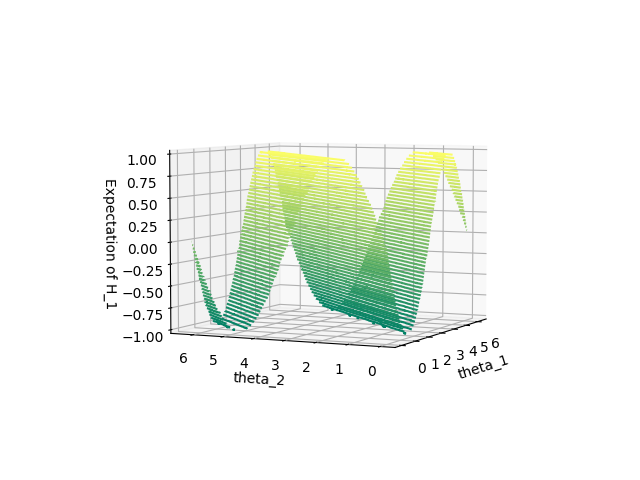

In [68]:
def energy_expectation(x, y):
  """ Returns meshgrid values for plotting """
  energy = np.zeros(x.shape)
  for idx, thetas in enumerate(x):
    for ind, theta1 in enumerate(thetas):
      params = np.array([np.pi/2, np.pi, theta1, y[idx][ind]])
      energy[idx][ind] = func(params)
  return energy

theta1 = np.linspace(0.0, 2*np.pi, 100)
theta2 = np.linspace(0.0, 2*np.pi, 100)

X, Y = np.meshgrid(theta1, theta2)
Z = energy_expectation(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='summer')
ax.set_xlabel('theta_1')
ax.set_ylabel('theta_2')
ax.set_zlabel('Expectation of H_1');
plt.show()


## Ansatz 2 (From Hint)

In [69]:
a, b, c = decompose_ham_to_pauli(H1)
params = np.random.uniform(-np.pi, np.pi, 1)
func = ft.partial(vqe, meas_basis=a, coeffs=b, circuit=ansatz2, 
                  num_qubits=2, shots=2048)

In [70]:
res = sp.optimize.minimize(func, params, method='Powell')
res

   direc: array([[-7.27080612e-05]])
     fun: array(-1.)
 message: 'Optimization terminated successfully.'
    nfev: 52
     nit: 2
  status: 0
 success: True
       x: array([-3.12289634])

In [71]:
assert(float(res.fun) == min(np.linalg.eig(H1)[0])) #Sanity Check

### Visualizing the Result

We scan over the paramter $\theta \in [0,2\pi]$, to visualize the change in expectation value for the ansatz2, which is inspired from the hint given.

<IPython.core.display.Javascript object>


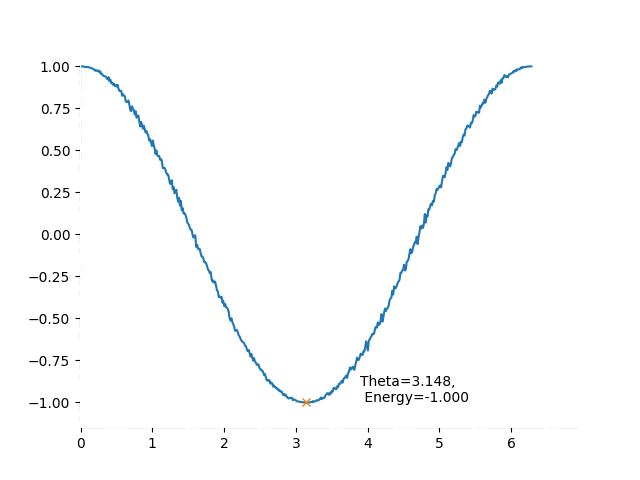

In [73]:
thetas = np.linspace(0.0, 2*np.pi, 500)
energy = np.zeros(len(thetas))

for idx, theta in enumerate(thetas):
    energy[idx] = func([theta])    

fig = plt.figure()
plt.plot(thetas, energy)
plt.title('Expectation value w.r.t angle theta')
plt.ylabel('Expectation value of $H_1$')
plt.xlabel('Theta (radians)')
indices = [idx for idx, x in enumerate(energy) if x <= -1.0]
xmin = thetas[indices[len(indices)//2]]
ymin = energy.min()
text= "Theta={:.3f}, \n Energy={:.3f}".format(xmin, ymin)
plt.plot(xmin,ymin,'x')
plt.annotate(text, xy=(xmin+0.75, ymin))
fig.show()


# **Excited States of the Hamiltonian**



One of the way to find the $k^{th}$ exicted states of a Hamiltonian would be to update the Hamiltonain $H$ to $H_{k}$ as follows:
$$ H_{k} = H + \sum_{i=0}^{k-1}\beta_{i}|i\rangle\langle i|$$
**For example:** To find the first excited state, we find $H_1 = H + \beta_0 |g\rangle\langle g|$, where $g$ is the ground state of the Hamiltonian. This works because of spectral decomposition.

This can be used to update our cost function, $C_{k}$, as follows:
$$ C(\theta_{k}) = \langle \psi(\theta_k)| H | \psi (\theta_k) \rangle + \sum_{i=0}^{k-1} \beta_{i} |\langle \psi(\theta_k) | \psi(\theta_{i})\rangle|^{2} $$ 

We'd already calculated the first term in VQE, but to calculate the next
summation term, we refer to [[2](https://arxiv.org/pdf/1805.08138.pdf)]. It suggests us to rewrite the overlap term $|\langle \psi(\theta_k)|\psi(\theta_{i})\rangle|^{2}$ as $|\langle00|U(\theta_{k})^{\dagger}U(\theta_{i})|00\rangle |^{2}$. Therefore, we can prepare the state $U(\theta_{k})^{\dagger}U(\theta_{i})|00\rangle$ using the trial state preparation circuit for current state and $i^{th}$ previously-computed state. 

This technique is known as ***Variational Quantum Deflation*** and requires the same number of qubits as ***Variational Quantum Eigensolver*** and around twice the circuit depth.

In [185]:
def vqd_cost(thetak, thetai, func, circuit, num_qubits, beta, shots=2048):
    """  Returns cost for VQD """
    
    energy = func(thetak)

    for idx, theta in enumerate(thetai):
        ansatz = circuit(theta, num_qubits) + circuit(thetak, num_qubits).inverse()
        ansatz.measure_all()
        backend = Aer.get_backend('qasm_simulator')
        result = execute(ansatz, backend, shots=shots).result()
        energy += beta[idx]*result.get_counts().get('00 00', 0)/shots

    return energy

def vqd(hamiltonian, circuit, num_qubits, params_shape, beta):
    """ 
        Runs Variational Quantum Deflation algorithm on a given Hamiltonian
        to give its excited eigenvalues.

        Args: 
        hamiltonian (matrix(ndarray)): Hamiltonian for 
        circuit (Quantum Circuit): ansatz template
        num_qubits (int): number of qubits to make an ansatz
        params_shape (tuple): shape tuple for parameters in ansatz
        beta (int): beta coefficent for VQD

        Returns:
        energy (vector(ndarray)): Calculated eigen energies for the Hamiltonian. 
    """

    a, b, c = decompose_ham_to_pauli(hamiltonian)
    initial_params  = np.random.uniform(-np.pi, np.pi, params_shape)
    func  = ft.partial(vqe, meas_basis=a, coeffs=b, circuit=circuit, 
                  num_qubits=num_qubits, shots=2048)
    res1 = sp.optimize.minimize(func, initial_params, method='Powell')
    energies = [float(res1.fun)]
    thetas = [np.reshape(res1.x, params_shape)]
    if len(beta) != np.shape(hamiltonian)[0]-1:
        raise ValueError('Length mismatch! Provide sufficient amount of beta_{i}')

    for eigst in range(np.shape(hamiltonian)[0]-1):
        cost = ft.partial(vqd_cost, thetai=thetas, func=func, circuit=circuit, 
                  num_qubits=num_qubits, beta=beta, shots=2048)
        res2 = sp.optimize.minimize(cost, initial_params, method='Powell')
        if res2.success:
            thetas.append(np.reshape(res2.x, params_shape))
            energies.append(float(res2.fun))
        else:
            raise ValueError('Minimization was not successful.')

    return energies


## Ansatz 1

In [194]:
excited_energies = vqd(H1, ansatz1, 2, (2,2), [3.5, 1e-1, 1e-3])
excited_energies

[-1.0, 0.9921875, 0.994189453125, 1.0003808593749999]

In [195]:
assert(np.allclose(np.asarray(excited_energies),  np.sort(np.linalg.eig(H1)[0]), atol=1e-2))

## Ansatz 2

In [196]:
excited_energies = vqd(H1, ansatz2, 2, 1, [2.7, 1e-2, 1e-3])
excited_energies

[-1.0, 0.99365234375, 1.0012158203125, 1.0074306640625]

In [197]:
assert(np.allclose(np.asarray(excited_energies),  np.sort(np.linalg.eig(H1)[0]), atol=1e-2))

# **Interpreting the Results**



1.   Both of our ansatz produced accurate results despite of ansatz 2 being more expressible than ansatz 1. One reason for this can be that the the ansatz 2 expressibility was covered the interested solution subspace. Another reason could be due to its more entangling capability.
2.   Convergence of VQE depends upon both the type of optimizer (gradient-based or point-search) and the choice of ansatz. In general more the number of parameters, and the depth of ansatz, more difficult will be the convergence.
3.   VQD was able to perform better as we adjusted the values of $\beta_{i}$ based on the difference between the eigen-energies. In general, values of these $\beta_{i}$ should be larger than the largest difference between the consecutive eigen-energies. 
